In [2]:
import os
from os.path import join
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

### Try to look at some hands dataset and their learning process.

In [1]:
import os
os.environ["KAGGLEHUB_CACHE"] = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/kaggle"

import kagglehub
path = kagglehub.dataset_download("koryakinp/fingers")
print("Path to dataset files:", path)

Path to dataset files: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/kaggle/datasets/koryakinp/fingers/versions/2


In [7]:
!ls {path}


fingers  test  train


In [2]:
dataset_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/kaggle/datasets/koryakinp/fingers/versions/2"
TRAIN_DIR = os.path.join(dataset_root, "train")
TEST_DIR = os.path.join(dataset_root, "test")
IMAGE_SIZE = (128, 128)  
def load_images_and_labels(directory):
    images = []
    labels = []
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        img = Image.open(file_path).resize(IMAGE_SIZE)
        images.append(np.array(img))
        label_part = file.split('_')[1]  
        label = int(label_part[0])       
        labels.append(label)
    return np.array(images), np.array(labels)
train_images, train_labels = load_images_and_labels(TRAIN_DIR)
test_images, test_labels = load_images_and_labels(TEST_DIR)
print(train_labels[0])
print(f"Train images: {train_images.shape}, Train labels: {train_labels.shape}")
print(f"Test images: {test_images.shape}, Test labels: {test_labels.shape}")

4
Train images: (18000, 128, 128), Train labels: (18000,)
Test images: (3600, 128, 128), Test labels: (3600,)


In [3]:
train_images.shape

(18000, 128, 128)

In [25]:
def compute_pca_stats(images, device="cuda", svd_lowrank=False, k=200):
    """Compute PCA statistics (mean, eigenvectors, eigenvalues) for a set of images
    
    Args:
        images: torch.Tensor or numpy.ndarray of shape (N, H, W) or (N, C, H, W)
        use_cuda: bool, whether to use GPU acceleration if available
    
    Returns:
        img_mean: torch.Tensor - mean image 
        eigval: torch.Tensor - eigenvalues in descending order
        eigvec: torch.Tensor - corresponding eigenvectors as columns
    """
    # Convert numpy to torch if needed
    if isinstance(images, np.ndarray):
        images = torch.from_numpy(images)
    # Ensure float type
    images = images.float()
    # Normalize to [0,1] if needed
    if images.max() > 1.0:
        images = images / 255.0
    # Move to GPU if requested
    if device == "cuda" and torch.cuda.is_available():
        images = images.cuda()
    # Reshape to (N, -1) for PCA
    N = images.shape[0]
    img_shape = images.shape[1:]
    X = images.view(N, -1)
    # Compute mean
    img_mean = torch.mean(X, dim=0)
    # Center the data
    X_centered = X - img_mean.unsqueeze(0)
    if svd_lowrank:
        # X_centered: (N, D), want top k PCs
        U, S, Vt = torch.svd_lowrank(X_centered, q=k, niter=2)
        # Vt is (k, D): each row is a principal component
        # If you want them as columns:
        eigvec = Vt  # (D, k)
        eigval = (S**2) / (N - 1)
    else:
        # Compute covariance matrix
        cov = torch.matmul(X_centered.T, X_centered) / (N - 1)
        # Compute eigendecomposition
        eigval, eigvec = torch.linalg.eigh(cov)
    # Sort in descending order
    sorted_indices = torch.argsort(eigval, descending=True)
    eigval = eigval[sorted_indices]
    eigvec = eigvec[:, sorted_indices]
    # Print summary statistics
    print(f"Mean shape: {img_mean.shape}")
    print(f"Mean value range: [{img_mean.min().item():.2f}, {img_mean.max().item():.2f}]")
    # print(f"Covariance matrix shape: {cov.shape}")
    print(f"Covariance eigval range: [{eigval.min().item():.2f}, {eigval.max().item():.2f}]")
    return img_mean, eigval, eigvec

In [9]:
# Convert to torch tensor and move to GPU
train_images_tensor = torch.from_numpy(train_images).float().cuda() / 255.0
# Reshape to (N, C*H*W) for covariance calculation
N = train_images_tensor.shape[0]
X = train_images_tensor.view(N, -1)
# Compute mean
img_mean = torch.mean(X, dim=0)
# Center the data
X_centered = X - img_mean.unsqueeze(0)
# Compute covariance matrix
cov = torch.matmul(X_centered.T, X_centered) / (N - 1)
eigval, eigvec = torch.linalg.eigh(cov)
# Sort eigenvalues and eigenvectors in descending order
sorted_indices = torch.argsort(eigval, descending=True)
eigval = eigval[sorted_indices]
eigvec = eigvec[:, sorted_indices]
print(f"Mean shape: {img_mean.shape}")
print(f"Mean value range: [{img_mean.min().item():.2f}, {img_mean.max().item():.2f}]")
print(f"Covariance matrix shape: {cov.shape}")
print(f"Covariance eigval range: [{eigval.min().item():.2f}, {eigval.max().item():.2f}]")

Mean shape: torch.Size([16384])
Mean value range: [0.19, 0.71]
Covariance matrix shape: torch.Size([16384, 16384])
Covariance eigval range: [-0.00, 18.69]


In [19]:
img_mean.shape

torch.Size([49152])

In [29]:
def plot_eigenvectors(img_mean, eigval, eigvec, eigen_ids, img_shape=(128, 128), avg_color_channel=False):
    n_eigen = len(eigen_ids)
    ncols = 5
    nrows = (n_eigen + ncols ) // ncols
    plt.figure(figsize=(15, 3 * nrows))
    plt.subplot(nrows, ncols, 1)
    if len(img_shape) == 2:
        plt.imshow(img_mean.reshape(img_shape).cpu().numpy(), cmap='gray')
    else:
        plt.imshow(img_mean.reshape(img_shape).permute(1, 2, 0).cpu().numpy())
    plt.title('Mean Image')
    plt.axis('off')

    for i, eigen_id in enumerate(eigen_ids):
        plt.subplot(nrows, ncols, i + 2)
        # Reshape eigenvector back to image dimensions
        if len(img_shape) == 2:
            eigvec_img = eigvec[:, eigen_id].reshape(img_shape).cpu().numpy()
            plt.imshow(eigvec_img, cmap='RdBu')
        else:
            eigvec_img = eigvec[:, eigen_id].reshape(img_shape).permute(1, 2, 0).cpu().numpy()
            if avg_color_channel:
                eigvec_img = np.mean(eigvec_img, axis=-1)
                plt.imshow(eigvec_img, cmap='RdBu')
            else:
                plt.imshow(eigvec_img / eigvec_img.std())
        
        # Plot with a diverging colormap centered at 0
        plt.title(f'Eig{eigen_id}={eigval[eigen_id]:.1e}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


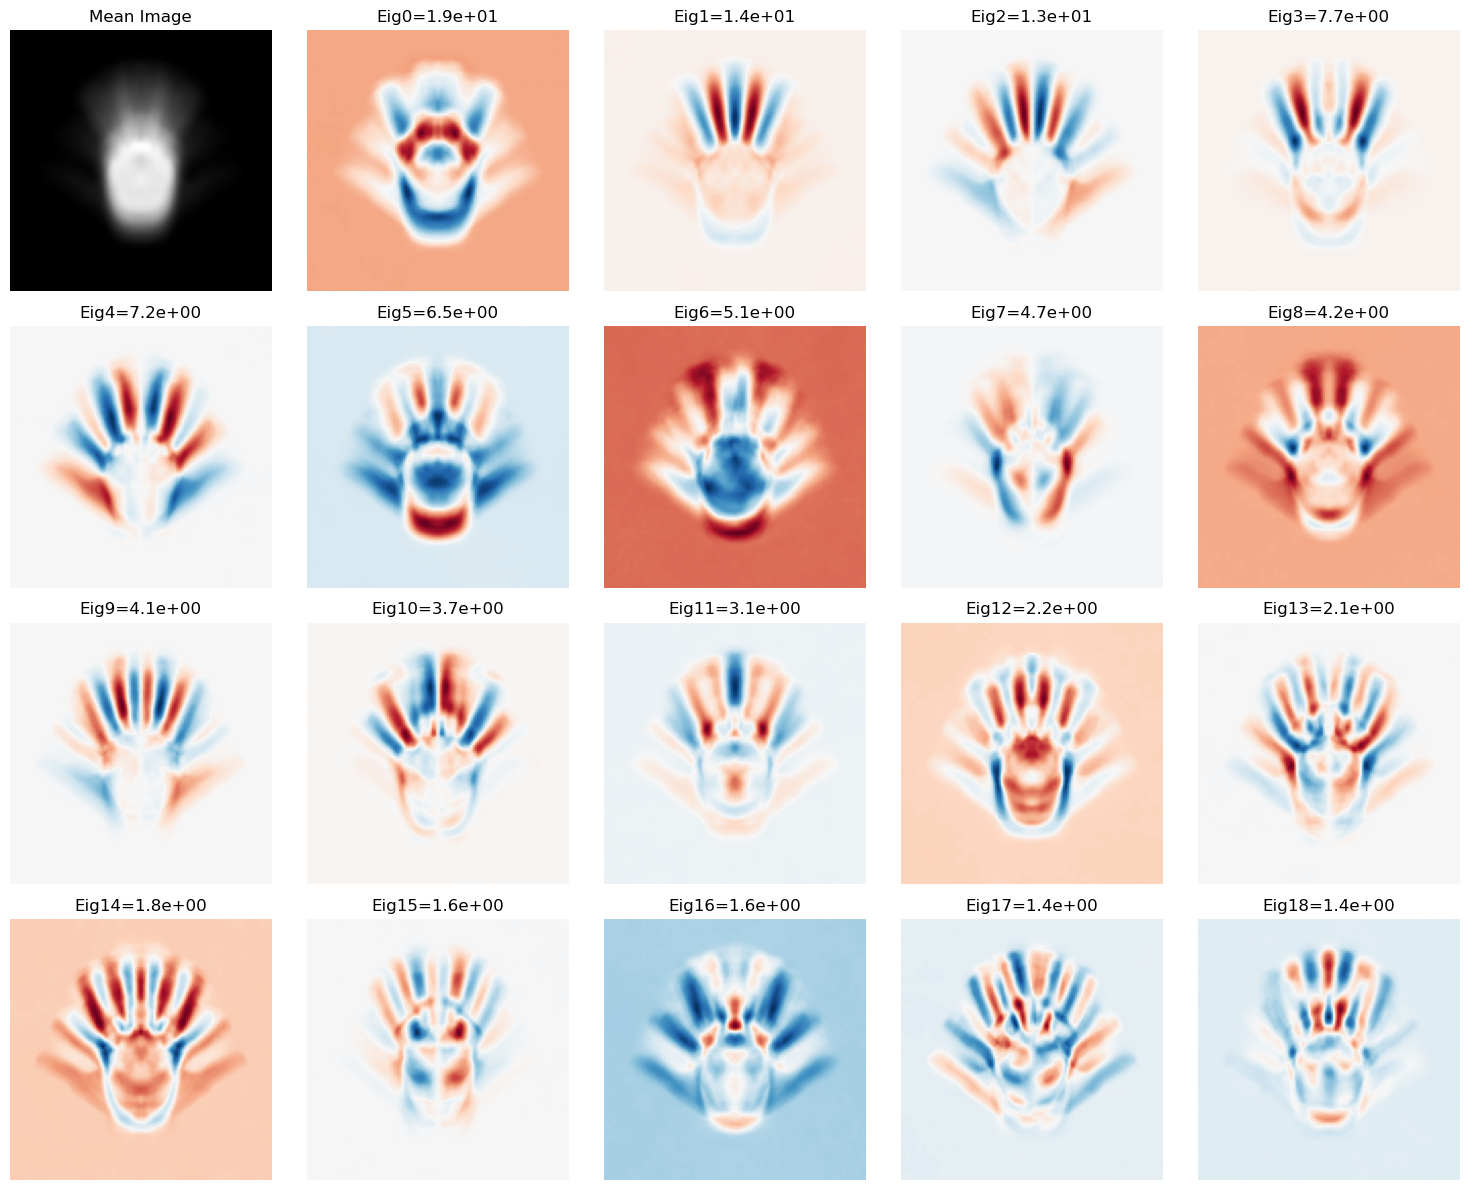

In [31]:
# Example usage:
plot_eigenvectors(img_mean.cpu(), eigval.cpu(), eigvec.cpu(), eigen_ids=range(0,19))  # Plot first 5 eigenvectors

In [25]:
# Calculate cumulative sum of eigenvalues
cumsum = torch.cumsum(eigval, dim=0)
total_variance = torch.sum(eigval)
variance_ratio = cumsum / total_variance

# Find number of components needed for 99% variance
n_components_95 = torch.where(variance_ratio >= 0.95)[0][0].item() + 1

print(f"Number of components needed for 95% variance: {n_components_95}")
print(f"Total number of components: {len(eigval)}")
print(f"Percentage of components used: {(n_components_95/len(eigval)*100):.1f}%")

Number of components needed for 95% variance: 457
Total number of components: 16384
Percentage of components used: 2.8%


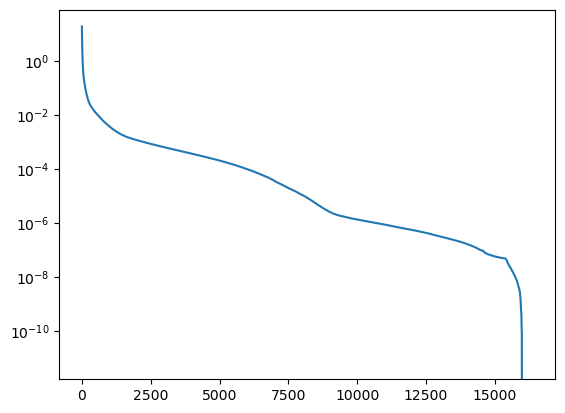

In [22]:
plt.plot(eigval.cpu())
plt.yscale('log')

### CMU hands dataset

In [8]:
import json
import numpy as np
from glob import glob
from tqdm import trange, tqdm
import torchvision.transforms as T

In [3]:
hands_dataset_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/HandsDatasets/CMU_Panoptic"

In [4]:
hands_synth_dir = join(hands_dataset_root, "hand_labels_synth")
hands_manual_dir = join(hands_dataset_root, "hand_labels")

In [7]:
!ls {hands_synth_dir}

output_viz_synth  readme.txt  synth1  synth2  synth3  synth4


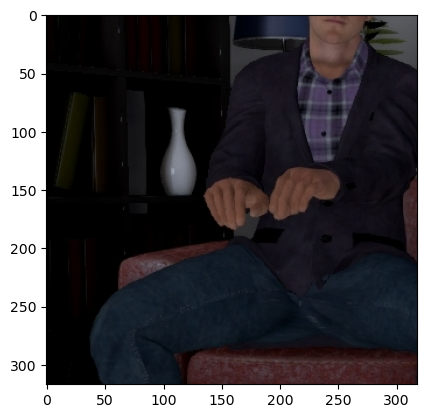

In [6]:
import json
# load image and label
for img_idx in range(1, 10):
    synth_img = Image.open(join(hands_synth_dir, "synth1", f"{img_idx:04d}.jpg"))
    label = json.load(open(join(hands_synth_dir, "synth1", f"{img_idx:04d}.json")))
    plt.imshow(synth_img)

In [46]:
labels[1]

{'hand_pts': [[152.03500366210938, 209.26100158691406, 1.0],
  [155.7050018310547, 195.73599243164062, 1.0],
  [158.96099853515625, 182.05299377441406, 1.0],
  [165.9810028076172, 171.0970001220703, 1.0],
  [0.0, 0.0, 0.0],
  [172.52699279785156, 175.89700317382812, 1.0],
  [182.8419952392578, 168.04100036621094, 1.0],
  [192.38400268554688, 161.4340057373047, 1.0],
  [0.0, 0.0, 0.0],
  [179.072998046875, 180.73599243164062, 1.0],
  [189.74899291992188, 171.86500549316406, 1.0],
  [196.75799560546875, 166.23300170898438, 1.0],
  [0.0, 0.0, 0.0],
  [181.92100524902344, 187.10800170898438, 1.0],
  [190.85000610351562, 179.3730010986328, 1.0],
  [195.89100646972656, 175.05299377441406, 1.0],
  [0.0, 0.0, 0.0],
  [184.1580047607422, 195.7429962158203, 1.0],
  [193.85699462890625, 185.7030029296875, 1.0],
  [197.32899475097656, 182.13299560546875, 1.0],
  [0.0, 0.0, 0.0]],
 'is_left': 0}

In [9]:
# Define transform to resize and crop images
transform = T.Compose([
    T.ToTensor(),
    T.Resize(128, antialias=True),  # Resize shorter side to 128
    T.CenterCrop(128)  # Crop to square
])

img_files = sorted(glob(join(hands_synth_dir, "synth1", "*.jpg")))
# load images and labels into arrays
synth_imgs = []
labels = []
for img_idx in trange(1, len(img_files)+1):
    synth_img = Image.open(join(hands_synth_dir, "synth1", f"{img_idx:04d}.jpg"))
    label = json.load(open(join(hands_synth_dir, "synth1", f"{img_idx:04d}.json")))
    # Apply transforms and convert to numpy array
    synth_img = transform(synth_img)
    synth_imgs.append(synth_img)
    labels.append(label)

# Convert list of images to numpy array
synth_imgs = torch.stack(synth_imgs)

print(f"Loaded {len(synth_imgs)} images with shape {synth_imgs.shape}")
print(f"Loaded {len(labels)} label dictionaries")

100%|██████████| 6546/6546 [00:24<00:00, 267.72it/s]


Loaded 6546 images with shape torch.Size([6546, 3, 128, 128])
Loaded 6546 label dictionaries


In [37]:
img_mean, eigval, eigvec = compute_pca_stats(synth_imgs, device="cuda", svd_lowrank=True, k=1000)

Mean shape: torch.Size([49152])
Mean value range: [0.12, 0.35]
Covariance eigval range: [0.02, 608.05]


In [27]:
eigvec.shape

torch.Size([49152, 200])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

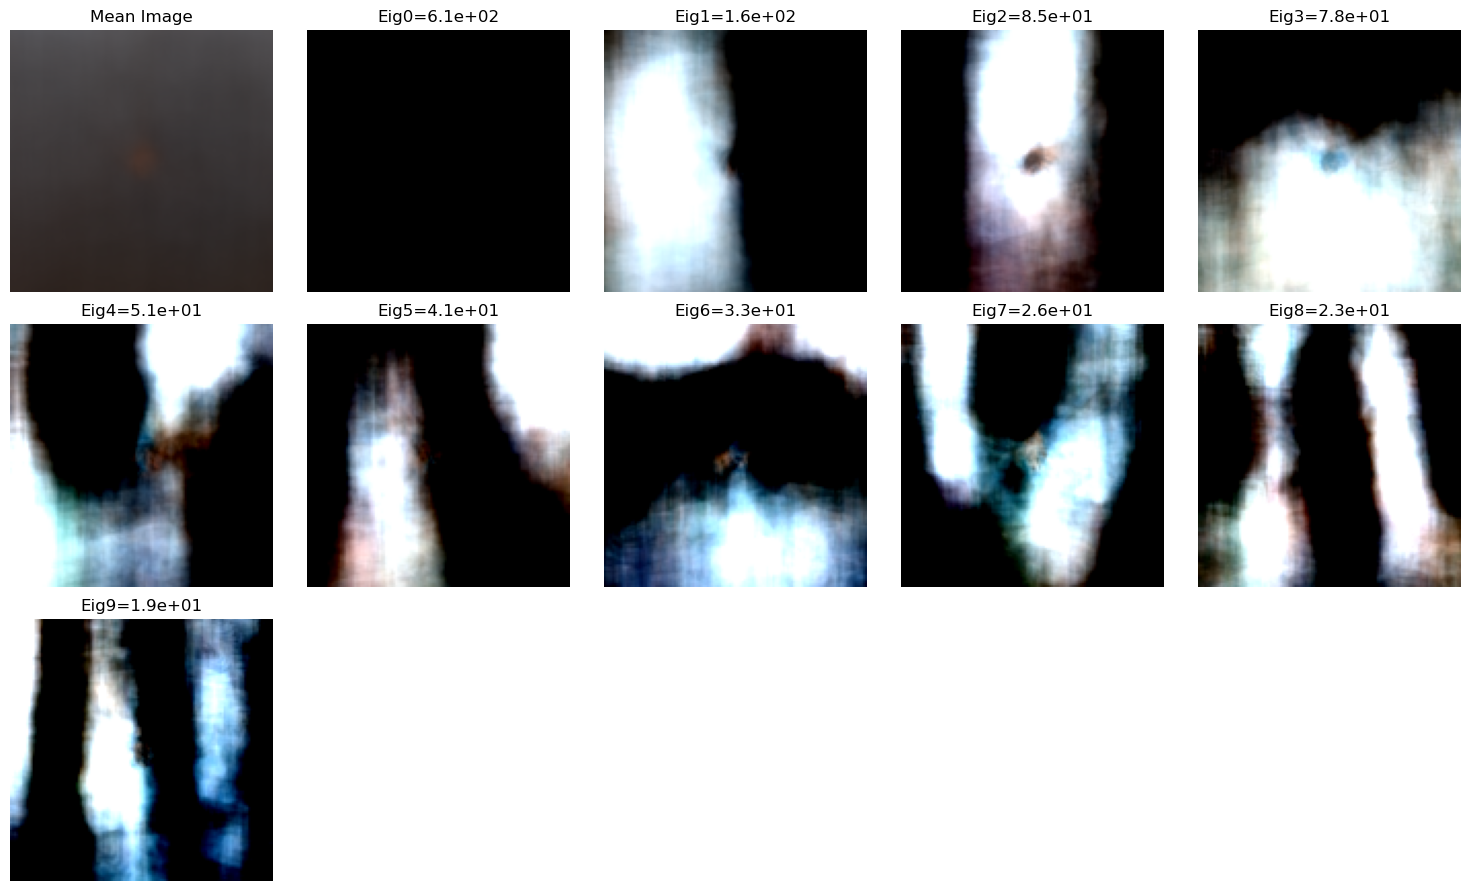

In [43]:
plot_eigenvectors(img_mean.cpu(), eigval.cpu(), eigvec.cpu(), eigen_ids=range(0,10), img_shape=(3, 128, 128), avg_color_channel=False)

In [ ]:
!ls {hands_synth_dir}/synth1

0001.jpg   0936.json  1872.jpg	 2807.json  3743.jpg   4678.json  5614.jpg
0001.json  0937.jpg   1872.json  2808.jpg   3743.json  4679.jpg   5614.json
0002.jpg   0937.json  1873.jpg	 2808.json  3744.jpg   4679.json  5615.jpg
0002.json  0938.jpg   1873.json  2809.jpg   3744.json  4680.jpg   5615.json
0003.jpg   0938.json  1874.jpg	 2809.json  3745.jpg   4680.json  5616.jpg
0003.json  0939.jpg   1874.json  2810.jpg   3745.json  4681.jpg   5616.json
0004.jpg   0939.json  1875.jpg	 2810.json  3746.jpg   4681.json  5617.jpg
0004.json  0940.jpg   1875.json  2811.jpg   3746.json  4682.jpg   5617.json
0005.jpg   0940.json  1876.jpg	 2811.json  3747.jpg   4682.json  5618.jpg
0005.json  0941.jpg   1876.json  2812.jpg   3747.json  4683.jpg   5618.json
0006.jpg   0941.json  1877.jpg	 2812.json  3748.jpg   4683.json  5619.jpg
0006.json  0942.jpg   1877.json  2813.jpg   3748.json  4684.jpg   5619.json
0007.jpg   0942.json  1878.jpg	 2813.json  3749.jpg   4684.json  5620.jpg
0007.json  0943.jpg   1878

### MPII human pose dataset

https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1.tar.gz

https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1_u12_2.zip

### Scratch

In [ ]:
img_files = sorted(glob(join(hands_synth_dir, "synth1", "*.jpg")))
# load images and labels into arrays
synth_imgs = []
labels = []
for img_idx in trange(1, len(img_files)+1):
    synth_img = Image.open(join(hands_synth_dir, "synth1", f"{img_idx:04d}.jpg"))
    label = json.load(open(join(hands_synth_dir, "synth1", f"{img_idx:04d}.json")))
    synth_imgs.append(np.array(synth_img))
    labels.append(label)

# Convert list of images to numpy array
synth_imgs = np.array(synth_imgs)

print(f"Loaded {len(synth_imgs)} images with shape {synth_imgs.shape}")
print(f"Loaded {len(labels)} label dictionaries")

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6546,) + inhomogeneous part.

In [ ]:
for i in range(10):
    print(synth_imgs[i].shape)

(328, 329, 3)
(359, 359, 3)
(355, 354, 3)
(498, 497, 3)
(336, 336, 3)
(345, 345, 3)
(380, 380, 3)
(364, 363, 3)
(317, 318, 3)
(343, 342, 3)
